# Using llamacpp server on localhost:8080
llama-server exposes an OpenAI-compatible API, so you can use the official OpenAI SDK as if it were OpenAI

In [11]:
from openai import OpenAI
from pprint import pprint

client = OpenAI(base_url="http://localhost:8080", api_key="anysadaas")  # llama-server endpoint

resp = client.chat.completions.create(
    model="gemma-3",
    messages=[
        {
            "role": "user",
            "content": "What is tourbillion",
        }
    ],
    temperature=0.7,
    max_tokens=200,
)

pprint(resp.choices[0].message.content)

('Okay, let\'s break down what a "tourbillion" is – it’s a surprisingly '
 "complex and fascinating meteorological phenomenon! Here's a breakdown of the "
 'key aspects:\n'
 '\n'
 '**1. The Basic Definition: A Rapidly Rotating Cloud**\n'
 '\n'
 'At its core, a tourbillion is a **rapidly rotating, vertically-oriented '
 'vortex** of air. Think of it as a giant, incredibly powerful, swirling storm '
 'cloud.\n'
 '\n'
 '**2. How They Form – The Process**\n'
 '\n'
 '* **Warm, Moist Air Rises:** Tourbillion formation usually starts with warm, '
 'moist air rising from the ground.\n'
 '* **Convergence:** As this air rises, it begins to converge (come together) '
 'due to terrain features like mountains or coastlines.\n'
 '* **Rotation:**  The converging air creates an area of lower pressure. This '
 'low pressure encourages the air to rotate horizontally.\n'
 '* **Strong Coriolis Effect:**  The Earth’s rotation (the Coriolis Effect) '
 'then starts to influence the')


# Declaring Langchain Tools

In [12]:
from langchain.tools import tool

@tool
def search(query: str) -> str:
    """Search for information."""
    return f"Results for: {query}"


@tool
def get_weather(location: str) -> str:
    """Get weather information for a location."""
    return f"Weather in {location}: Sunny, 72°F"

# Using declared tools

In [13]:
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI

model = ChatOpenAI(
    model="gemma-3",
    temperature=0.1,
    max_tokens=500,
    timeout=30,
    base_url="http://localhost:8080",
    api_key="anyapikey"
)
agent = create_agent(
    model, system_prompt="You are a helpful assistant. Be concise and accurate."
)
result = agent.invoke(
    {"messages": [{"role": "user", "content": "What's the weather in San Francisco?"}]}
)
pprint(result)

{'messages': [HumanMessage(content="What's the weather in San Francisco?", additional_kwargs={}, response_metadata={}, id='3dce08bf-05c1-4939-b4ad-d3e1a3ead645'),
              AIMessage(content='Right now, in San Francisco, it’s partly cloudy with a temperature of 65°F (18°C). The wind is light and blowing from the west at 8 mph.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 30, 'total_tokens': 72, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'gemma-3', 'system_fingerprint': 'b7120-054a45c3d', 'id': 'chatcmpl-ottSZK9o09wdywxPirGl0DCseZvboIb1', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--7374e3d1-c664-4c2f-b516-c99d08a7b649-0', usage_metadata={'input_tokens': 30, 'output_tokens': 42, 'total_tokens': 72, 'input_token_details': {}, 'output_token_details': {}})]}


In [14]:
from pydantic import BaseModel
from langchain.agents.structured_output import ToolStrategy


class ContactInfo(BaseModel):
    name: str
    email: str
    phone: str

agent = create_agent(
    model,
    system_prompt="You are a helpful assistant. Be concise and accurate.",
    tools=[search],
    response_format=ToolStrategy(ContactInfo),
)

for i in range(1):
    result = agent.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": "From the following mixed and somewhat chaotic text, extract ONLY the real contact information (full name, email, and phone number). Ignore any decoy or misleading data, fictional metadata, or extraneous narrative elements. Text: 'In the quarterly report drafted by the Orion Task Group, alongside references to obsolete protocols and placeholder personnel such as Marlene Quarkson (marlene.q@fake-domain.test) and the deprecated hotline number +99 123 000 0000, the actual point of interest concerns John Doe, john@example.com, (555) 123-4567, Jane Digg, jdigg@example.com, (123) 453-3321 who was listed after the archive checksum notes [CHK-2281-A]. Additional noise: <tempID:0049>, REF*BETA::/NULL, contact: nobody@noreply.invalid, 000-000-0000.' Extract only the legitimate contact details for Doe.",
                }
            ]
        }
    )

    pprint(result["structured_response"])

ContactInfo(name='John Doe', email='john@example.com', phone='(555) 123-4567')


# Start testing LangGraph Dev
Sample node
START -> Node -> END

In [30]:
from typing import Dict, TypedDict, List
from langgraph.graph import StateGraph, START, END

### Define Agent state

In [35]:
class AgentState(TypedDict):
    name: str
    age: str
    final: str
    message: str
    
    number1: int
    operation: str
    number2: int
    finalNumber: int
    
def greeting_node(state: AgentState) -> AgentState:
    state['message'] = "Hey " + state['message'] + ", how is your day going?"
    return state

def first_node(state: AgentState) -> AgentState:
    state['final'] = f"Hi {state['name']}"
    return state

def second_node(state: AgentState) -> AgentState:
    state['final'] = state['final'] + f" is {state['age']} years old"
    state['message'] = state['name']
    return state

def adder(state:AgentState) -> AgentState:
    state['finalNumber'] = state['number1'] + state['number2']
    return state

def subtract(state: AgentState) -> AgentState:
    state['finalNumber'] = state['number1'] - state['number2']
    return state

def decide_next_node(state: AgentState) -> AgentState:
    if state['operation'] == '+':
        return "addition_operation"
    elif state['operation'] == '-':
        return "subtract_operation"





### Build the graph

In [ ]:
graph = StateGraph(AgentState)

# graph.add_node("first", first_node)
# graph.add_node("second", second_node)
# graph.add_node("greeter", greeting_node)

graph.add_node('add', adder)
graph.add_node('sub', subtract)
graph.add_node('router', lambda state:state)

graph.add_edge(START, "router")

graph.add_conditional_edges("router", decide_next_node, {"addition_operation": "add", "subtract_operation": "sub"})

graph.add_edge("add", END)
graph.add_edge("sub", END)


app = graph.compile()

### Display application graph

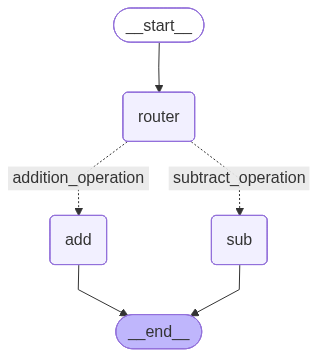

In [42]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [45]:
result = app.invoke({"number1": 4, "number2": 2, "operation": "-"})
pprint(result)

{'finalNumber': 2, 'number1': 4, 'number2': 2, 'operation': '-'}
